# Finding Critical Points with TensorFlow
## Part 2 - Critical Points of Neural Networks

This section is under construction.

In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from crit_finder import graphs, train, evaluate

The tricky part here is specifying the parameters: in order to calculate a Hessian, we need the parameters to be inside the same variable, but TensorFlow is not designed with the expectation that all of our weights need to be initialized at once. In addition, this makes keeping abstraction barriers up more difficult.

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


The biggest practical issue is handling the non-invertibility of the Hessian and related numerical issues in the Newton method. Seems like it requires fairly careful tuning of the step size, or else it can cause the performance to drop and/or the (raw) gradients to blow up.

In [4]:
fudged_hess_hyperparameters = {"layer_sizes":[10],
                            "nonlinearity":tf.nn.relu,
                            "input_size":784,
                            "output_size":10,
                             "learning_rate":0.01,
                             "newton_rate":5e-5,
                             "fudge_factor":1e-8,
                             "inverse_method": "fudged"
                            }

pseudo_inverse_hyperparameters = {"layer_sizes":[10],
                            "nonlinearity":tf.nn.relu,
                            "input_size":784,
                            "output_size":10,
                             "learning_rate":0.01,
                             "newton_rate":1e-5,
                             "minimum_eigenvalue_magnitude":1e-5,
                             "inverse_method": "pseudo"
                            }

gradmin_hyperparameters = {"layer_sizes":[10],
                            "nonlinearity":tf.nn.relu,
                            "input_size":784,
                            "output_size":10,
                            "learning_rate":0.01,
                            "gradient_norm_min_rate":1e-3,
                           "gradient_norm_momentum":0.99
                            }

In [5]:
num_steps_gd = 1000
gradient_descent_batch_size = 50
gradient_descent_track_every = 10

tracking_batch_size = 10000
print_tracking_data = False

num_steps_gnm = 500
num_steps_newton = 2
crit_finder_batch_size = 1000
gnm_track_every = 25
newton_track_every = 1

In [6]:
gradmin_network = graphs.make_neural_network(gradmin_hyperparameters)

crit_finder_str = "step_gradient_norm_min"

gd_results_gnm, gnm_results = train.train_and_track(gradmin_network, mnist, crit_finder_str,
                    num_steps_gd=num_steps_gd, gradient_descent_batch_size=gradient_descent_batch_size,
                      gradient_descent_track_every=gradient_descent_track_every,
                    tracking_batch_size=tracking_batch_size, print_tracking_data=print_tracking_data,
                    num_steps_crit_finder=num_steps_gnm, crit_finder_batch_size=crit_finder_batch_size,
                    crit_finder_track_every=gnm_track_every)

In [7]:
fn_network = graphs.make_neural_network(fudged_hess_hyperparameters)

crit_finder_str = "step_newton"

gd_results_fn, fudged_newton_results = train.train_and_track(fn_network, mnist, crit_finder_str,
                   num_steps_gd=num_steps_gd, gradient_descent_batch_size=gradient_descent_batch_size,
                   gradient_descent_track_every=gradient_descent_track_every,
                    tracking_batch_size=tracking_batch_size, print_tracking_data=print_tracking_data,
                    num_steps_crit_finder=num_steps_newton, crit_finder_batch_size=crit_finder_batch_size,
                   crit_finder_track_every=newton_track_every)

In [8]:
pn_network = graphs.make_neural_network(pseudo_inverse_hyperparameters)

crit_finder_str = "step_newton"

gd_results_pn, pseudo_newton_results = train.train_and_track(pn_network, mnist, crit_finder_str,
                   num_steps_gd=num_steps_gd, gradient_descent_batch_size=gradient_descent_batch_size,
                   gradient_descent_track_every=gradient_descent_track_every,
                    tracking_batch_size=tracking_batch_size, print_tracking_data=print_tracking_data,
                    num_steps_crit_finder=num_steps_newton, crit_finder_batch_size=crit_finder_batch_size,
                   crit_finder_track_every=newton_track_every)

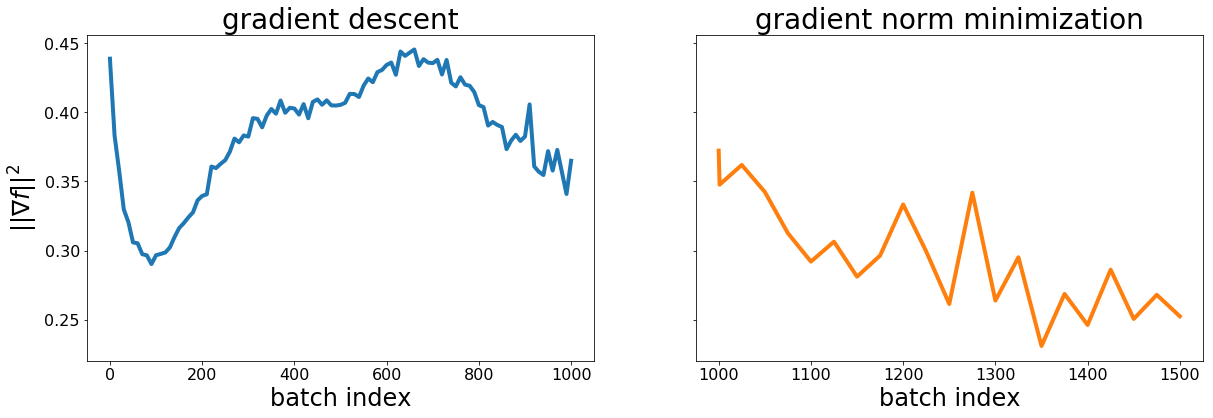

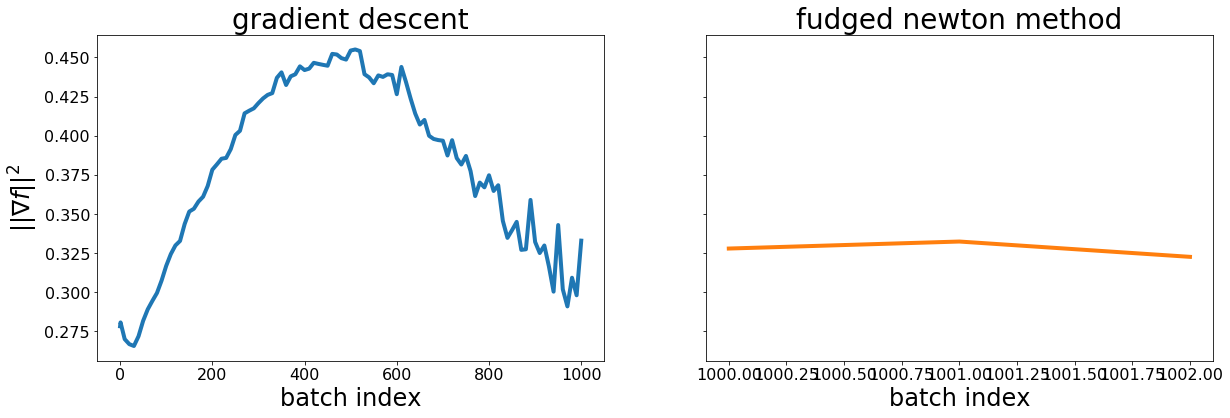

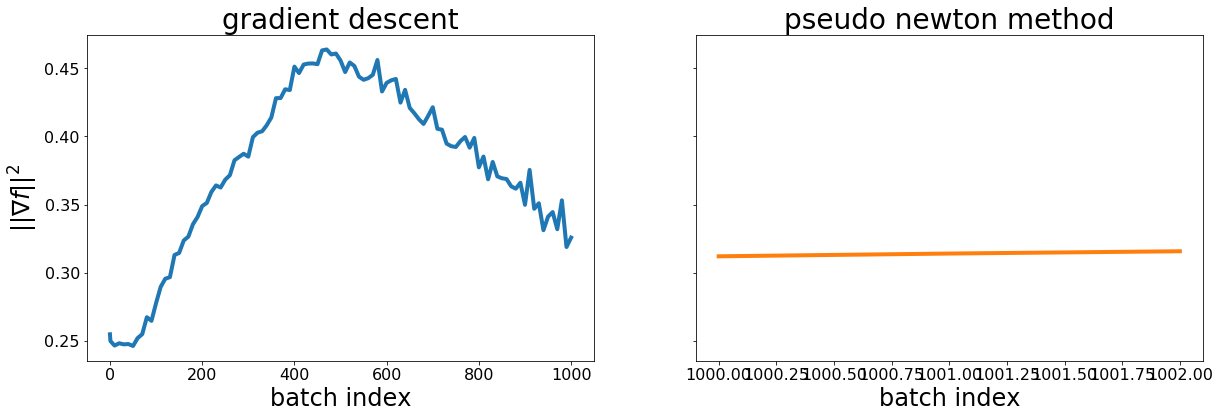

In [9]:
evaluate.plot_results(gd_results_gnm, gnm_results, "gradient norm minimization")
evaluate.plot_results(gd_results_fn, fudged_newton_results, "fudged newton method")
evaluate.plot_results(gd_results_pn, pseudo_newton_results, "pseudo newton method")

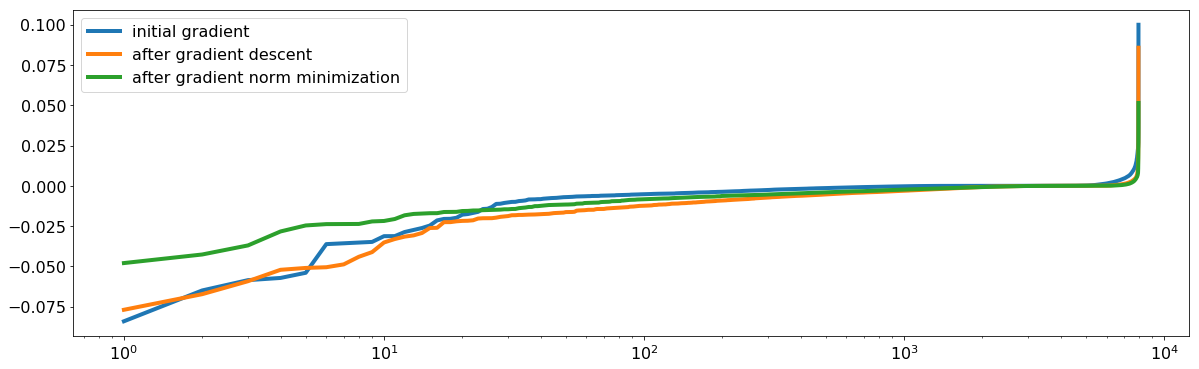

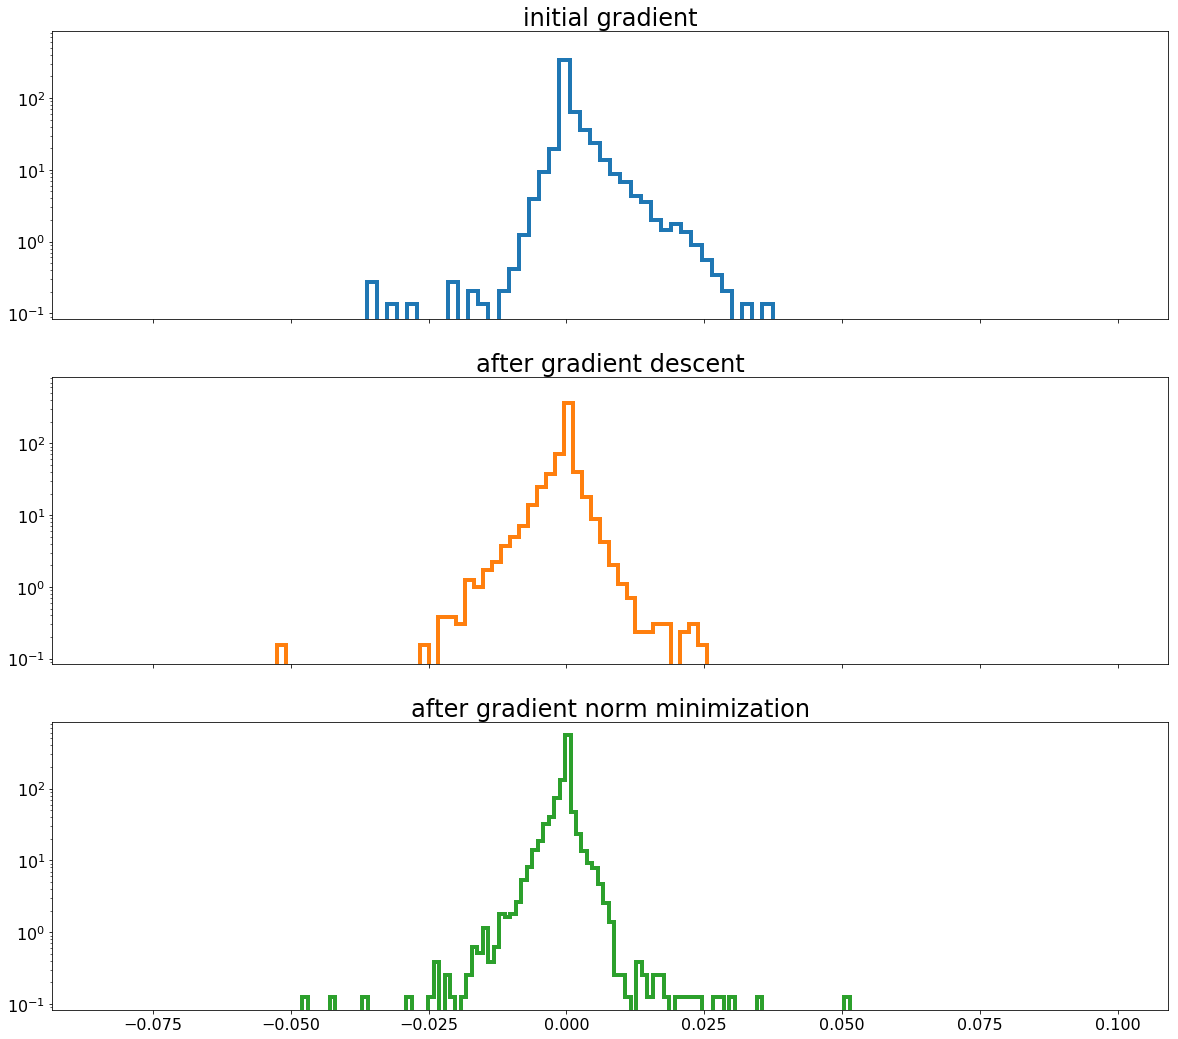

In [10]:
labels = ["initial gradient", "after gradient descent", "after gradient norm minimization"]

evaluate.compare_gradients_entrywise(gd_results_gnm, gnm_results, labels)

evaluate.compare_gradients_histogram(gd_results_gnm, gnm_results, labels)

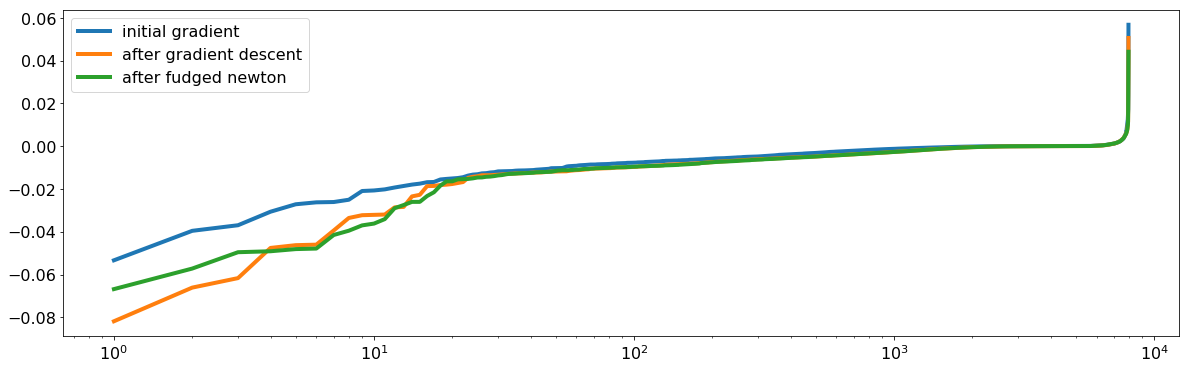

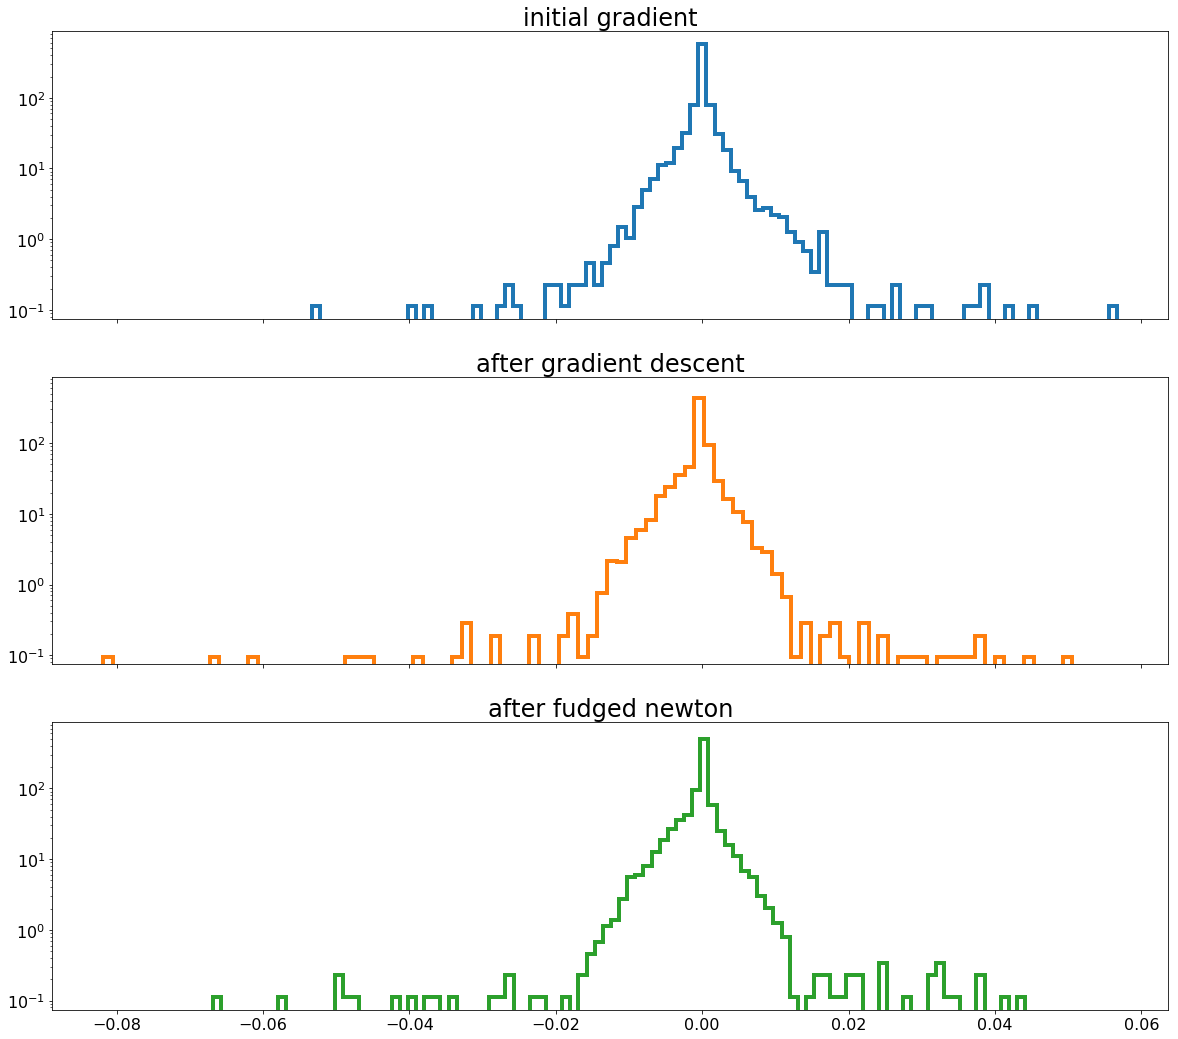

In [11]:
labels = ["initial gradient", "after gradient descent", "after fudged newton"]

evaluate.compare_gradients_entrywise(gd_results_fn, fudged_newton_results, labels)

evaluate.compare_gradients_histogram(gd_results_fn, fudged_newton_results, labels)

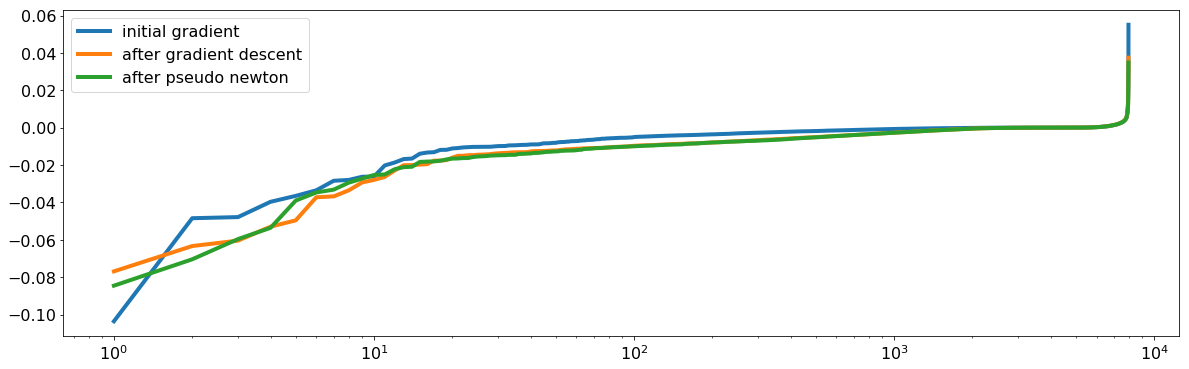

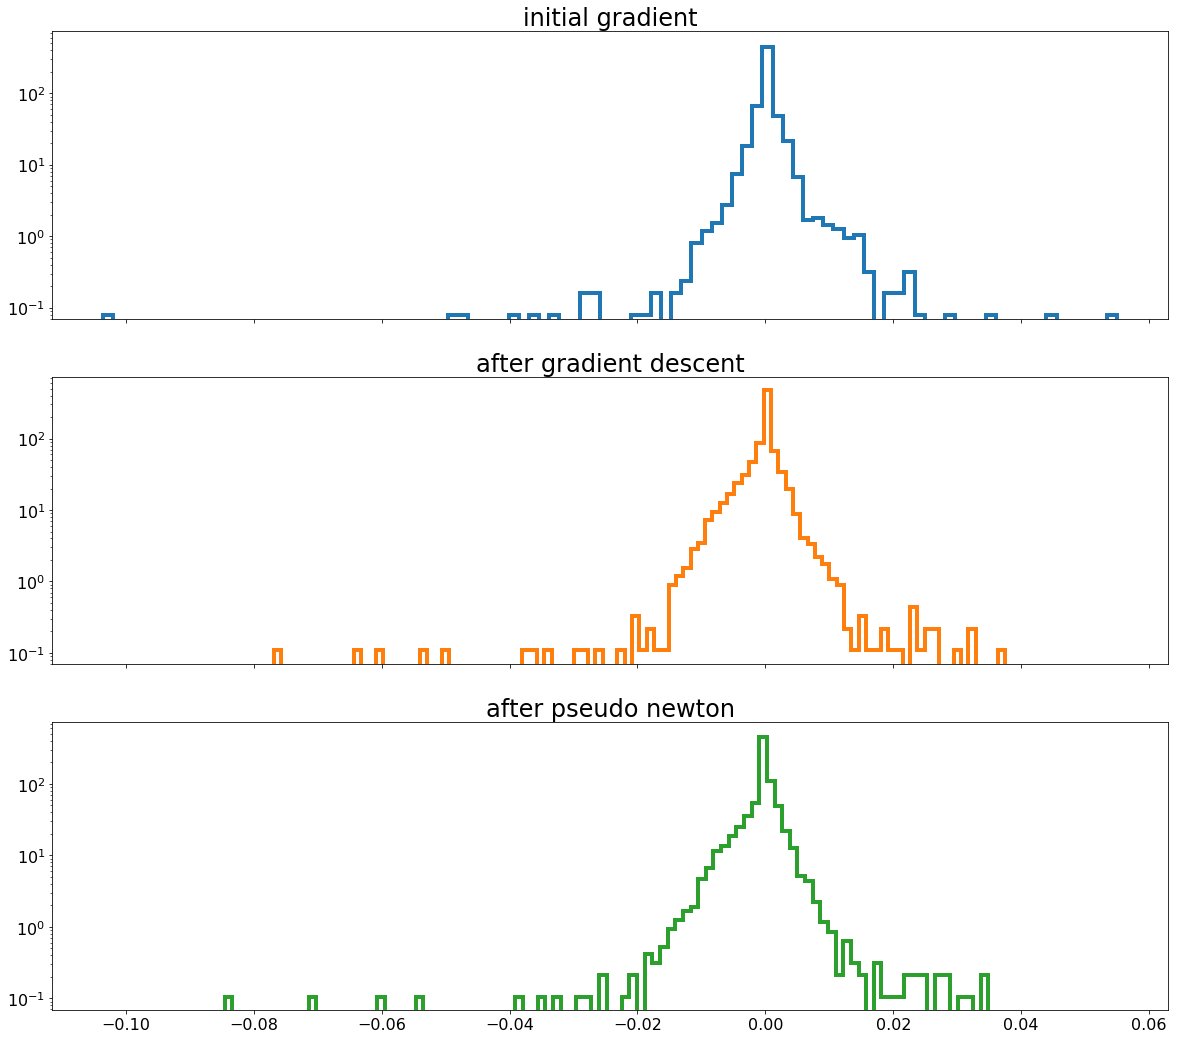

In [12]:
labels = ["initial gradient", "after gradient descent", "after pseudo newton"]

evaluate.compare_gradients_entrywise(gd_results_pn, pseudo_newton_results, labels)

evaluate.compare_gradients_histogram(gd_results_pn, pseudo_newton_results, labels)